# EDA on Subreddits Data

In this notebook, we will carry out EDA on our gathered data from the two subreddits, `r/keto` and `r/zerocarb`. Some of the insights may prove useful in our modeling. Here is what will be covered in this section:

1. [Exploring the Data](#Exploring-the-Data)
2. [Visualizations](#Visualizations)
    * [Upvotes Score](#Upvotes-Score)
    * [Upvote Ratio](#Upvote-Ratio)
    * [Number of Comments per post](#Number-of-Comments-per-post)
    * [Average Title Length in words](#Average-Title-length-in-words)
    * [Average Post length in words](#Average-Post-lenght-in-words)
    * [Average Volume of Posts per subreddit](#Average-Volume-of-posts-per-subreddit)
    
    
3. [Top Unigrams, Bigrams and Trigrams](#Top-Unigrams,-Bigrams-and-Trigrams)
4. [Top Unigrams, Bigrams and Trigrams (After Custom Stop Words removal)](#Top-Unigrams,-Bigrams-and-Trigrams-(After-Custom-Stop-Words-removal))

This is the third of four notebooks:</br>
[1. Subreddit Scraping](1_Subreddit_Scraping.ipynb)</br>
[2. Data Cleaning](2_Data_Cleaning.ipynb)</br>
**3. EDA on Cleaned Subreddits Data (Current Notebook)**</br>
[4. Modeling and Conclusions](4_Modeling_and_Conclusions.ipynb)</br>

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#### Reading in the data

In [2]:
# read in the data
keto = pd.read_csv('datasets/keto_cleaned.csv')
zerocarb = pd.read_csv('datasets/zerocarb_cleaned.csv')

# Exploring the Data

In [3]:
keto.describe()

,created_utc,num_comments,score,upvote_ratio,subreddit_subscribers,total_awards_received
count,9.864000e+03,9864.000000,9864.000000,9864.000000,9.864000e+03,9864.000000
mean,1.635974e+09,14.805454,1.412713,0.996026,2.663298e+06,0.002433
std,7.221397e+06,29.712874,9.529800,0.036109,1.489761e+05,0.071158
min,1.624394e+09,0.000000,0.000000,0.330000,2.456783e+06,0.000000
25%,1.629580e+09,0.000000,1.000000,1.000000,2.533511e+06,0.000000
50%,1.635436e+09,6.000000,1.000000,1.000000,2.629481e+06,0.000000
75%,1.642543e+09,17.000000,1.000000,1.000000,2.792626e+06,0.000000
max,1.648562e+09,486.000000,508.000000,1.000000,2.951551e+06,3.000000


In [4]:
zerocarb.describe()

,created_utc,num_comments,score,upvote_ratio,subreddit_subscribers,total_awards_received
count,9.805000e+03,9805.000000,9805.000000,1350.000000,7871.000000,4069.000000
mean,1.545873e+09,17.117695,8.905150,0.969667,80659.066192,0.002212
std,4.357812e+07,18.311057,21.071351,0.092311,27291.504269,0.051953
min,1.331051e+09,0.000000,0.000000,0.330000,27255.000000,0.000000
25%,1.527196e+09,6.000000,1.000000,1.000000,56427.500000,0.000000
50%,1.549069e+09,12.000000,2.000000,1.000000,83270.000000,0.000000
75%,1.573932e+09,22.000000,9.000000,1.000000,108331.000000,0.000000
max,1.648346e+09,394.000000,397.000000,1.000000,119970.000000,2.000000


<b>Observations:</b><br>
The `r/keto` subreddit has 3.0 million subscribers, and the `r/zerocarb` subreddit has 120 thousand subscribers, so on the surface we would expect that the `r/keto` subreddit might be more popular.
1. The `r/keto` subreddit has 1 upvotes per post on average compared to 8 upvotes per post on average for the `r/zerocarb` one. (We will compare daily post volume later on.)
2. The max upvotes for `r/keto` is higher than the `r/zerocarb` one, 641 upvotes vs 397 upvotes.
2. On average, each `r/keto` post gets 15 comments, compared to 17 for the `r/zerocarb` one. 
3. The max comments for `r/keto` is higher than the `r/zerocarb` one, 486 comments vs 394 comments.

From these figures, we can see that we cannot base popularity on just the number of subscribers a subreddit has. 
We would expect the max figures to be higher for `r/keto` as it has 24 times the number of subscribers `r/zerocarb` has. However the subscribers of `r/zerocarb` seem to be engaging more with each individual post.

---

# Visualizations

In this section, we will attempt to visualize the difference between `r/keto` and `r/zerocarb` and see if we can find insights which might help to explain some of our model's performance in the next notebook. Let's keep in mind the difference in subscriber count between the two subreddits.<br>
1. `r/keto`: 3M Subcribers
2. `r/zerocarb`: 120k Subscribers

Considering that a lot of the visalizations are going to be similar, I opted to create a custom function to help me with these plots.

In [5]:
def plot_hist_subplot(x_var, overall_title):
    """Accepts 2 texts inputs for feature names. The 
    dataset is hardcoded into this function."""
    
    # denoting figure size and subplots
    fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
    ax = ax.ravel()
    
    # creating chart 1
    chart1 = sns.histplot(data=keto, x=x_var, ax=ax[0], bins=5)
    mean1 = keto[x_var].mean()
    
    # using axvline will plot the vertical line across the entire y-axis
    # without having to specify the y-min and y-max
    ax[0].axvline(x=mean1, ls='--', color='black')
    
    # setting chart title, x-axis title, and y-axis title
    chart1.set_title(f'r/keto Mean: {round(mean1, 2)}', fontsize=15)
    chart1.set_xlabel(x_var, fontsize=15)
    chart1.set_ylabel('count', fontsize=15)
    
    # creating chart 1
    chart2 = sns.histplot(data=zerocarb, x=x_var, ax=ax[1], bins=5, color='darkorange')
    mean2 = zerocarb[x_var].mean()
    
    # using axvline will plot the vertical line across the entire y-axis
    # without having to specify the y-min and y-max
    ax[1].axvline(x=mean2, ls='--', color='black')
    
    # setting chart title, x-axis title, and y-axis title
    chart2.set_title(f'r/zerocarb Mean: {round(mean2, 2)}', fontsize=15)
    chart2.set_xlabel(x_var, fontsize=15)
    
    # setting overarching title
    plt.suptitle(overall_title, fontsize=20)
    # using tight_layout to improve chart layout
    plt.tight_layout();

## Upvotes Score

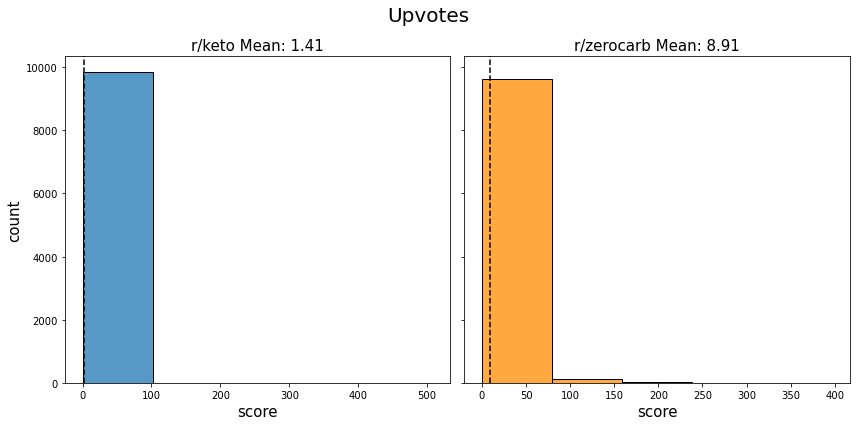

In [6]:
plot_hist_subplot('score', 'Upvotes')

We can clearly see that the subscribers of `r/zerocarb` seem to be more engaged on average, with each post getting about 9 points on average compared to each post of `r/keto` getting about 1.5 points on average.

## Upvote Ratio

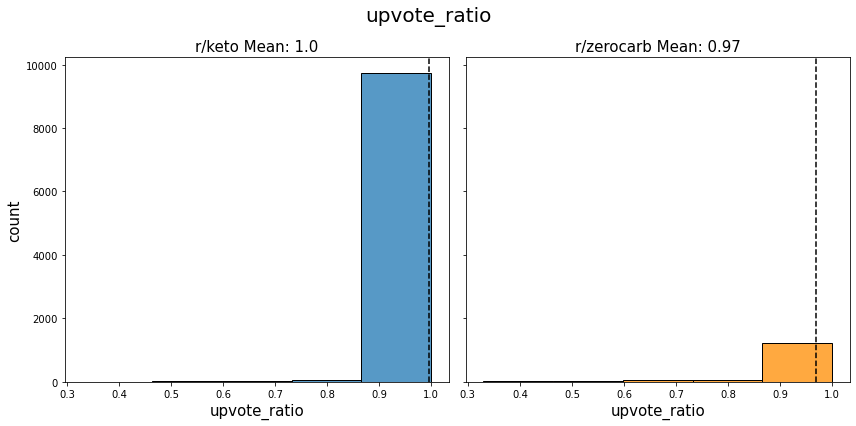

In [7]:
plot_hist_subplot('upvote_ratio', 'upvote_ratio')

The upvote ratio (ratio of upvotes compared to downvotes) seems to be pretty similar between the two subreddits, however considering the number of `r/keto` subcribers, a 100% upvote score is substantially more impressive. However we must also consider that this is only for the most recent 10_000 reddit posts, and nothing else. We will look at a date comparison between the two subreddits later on.

---

## Number of Comments per post

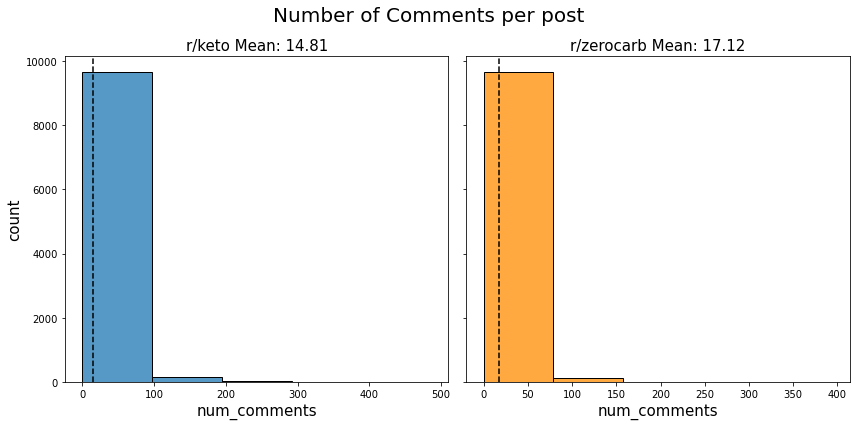

In [8]:
plot_hist_subplot('num_comments', 'Number of Comments per post')

For comments as well, we can see that the subcribers of `r/zerocarb` seem to be commenting more (17 comments) on average than the `r/keto` subscribers (15 comments) albeit only slightly. 

We seem to be seeing a trend here of higher engagement in general from the `r/zerocarb` reddit subscribers. 

---

Next we will plot the average number of words for `titles` and `selftext`. For this we will need to do a little preprocessing.

In [9]:
def num_words(text):
    """accept a string text and returns
    the number of words in the text"""
    
    num = text.split(' ')
    return len(num)

In [10]:
# applying custom 'num_words' function to 'title' and 'selftext'
# in both subreddits
keto['title_words'] = keto['title'].apply(num_words)
keto['selftext_words'] = keto['selftext'].apply(num_words)

zerocarb['title_words'] = zerocarb['title'].apply(num_words)
zerocarb['selftext_words'] = zerocarb['selftext'].apply(num_words)

Now we are ready to plot the average words per `title`/`selftext`

## Average Title length in words

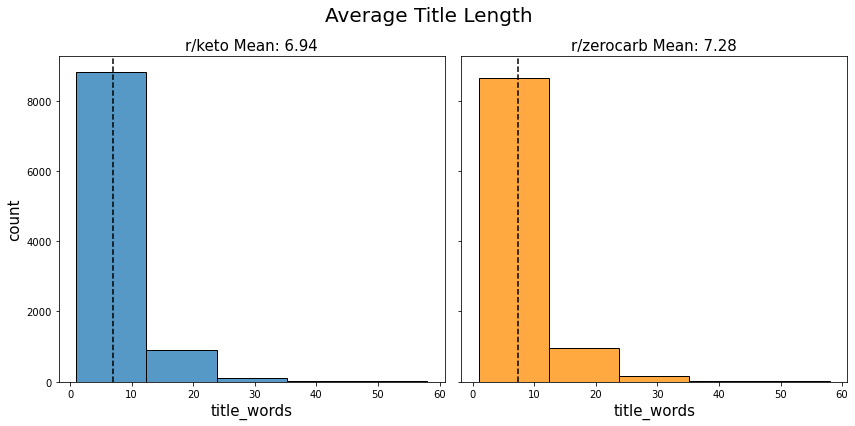

In [11]:
plot_hist_subplot('title_words', 'Average Title Length')

The titles length do not seem to have a major difference on average.

---

### Average Post length in words

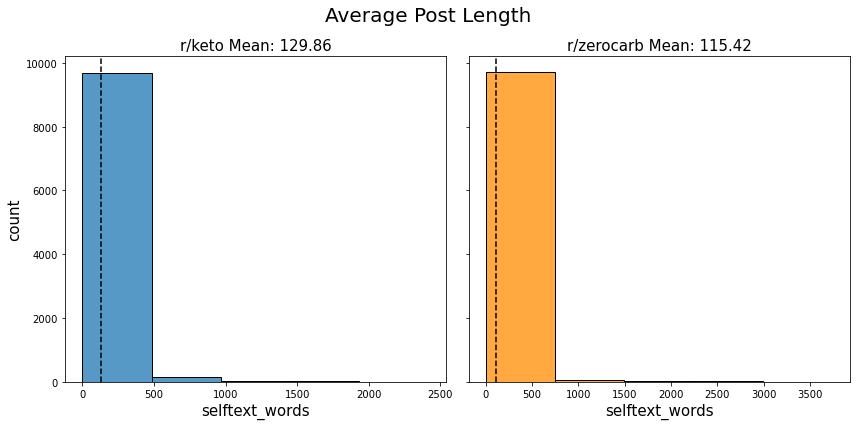

In [12]:
plot_hist_subplot('selftext_words', 'Average Post Length')

For the average length of the post, it seems that the subscribers of `r/keto` seem to type 1 sentence more (15 more words) than the subscribers of `r/zerocarb`.

---

### Average Volume of posts per subreddit

Now let's take a look at the average volumn of posts by date for each subreddit. For this as well we will need to do a bit of preprocessing. To plot the volume of posts against time, we will have to again convert our column to date time. Fortunately we already have a string date in the `date` column.

In [13]:
# converting string date to 'datetime' data type
keto['date'] = pd.to_datetime(keto['date'])
zerocarb['date'] = pd.to_datetime(zerocarb['date'])

# getting just the date and not the time
keto['date'] = keto['date'].map(lambda x: x.date())
zerocarb['date'] = zerocarb['date'].map(lambda x: x.date())

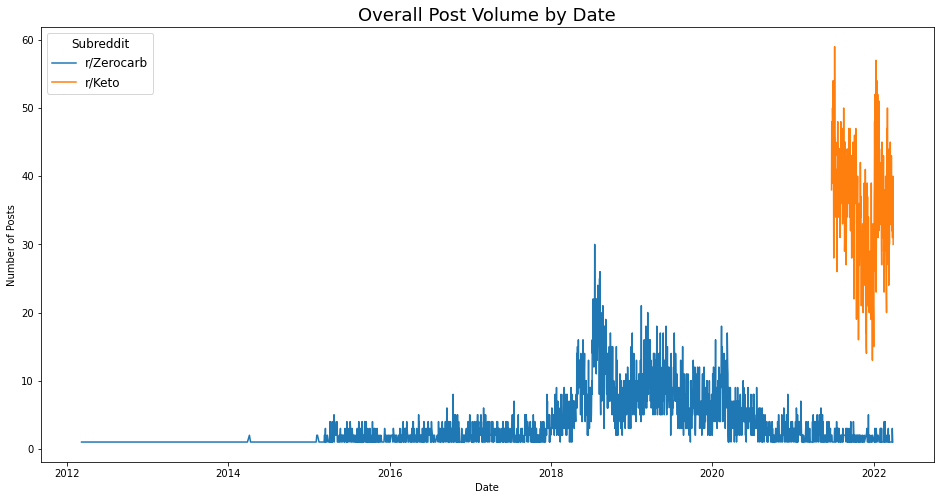

In [14]:
# denoting figure size and subplots
fig, ax = plt.subplots(1, 1, figsize=(16,8))

# plotting number of posts per day for each subreddit
zerocarb['date'].value_counts().plot()
keto['date'].value_counts().plot()

# setting x-axis, y-axis, chart title and legend
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Overall Post Volume by Date', fontsize=18)
legend = plt.legend(title='Subreddit', loc='best', labels=['r/Zerocarb', 'r/Keto'], fontsize=12)
legend.get_title().set_fontsize('12');

Let's take a closer look after 2020.

In [15]:
# creating temporary year column
zerocarb['year'] = zerocarb['date'].map(lambda x: x.year)

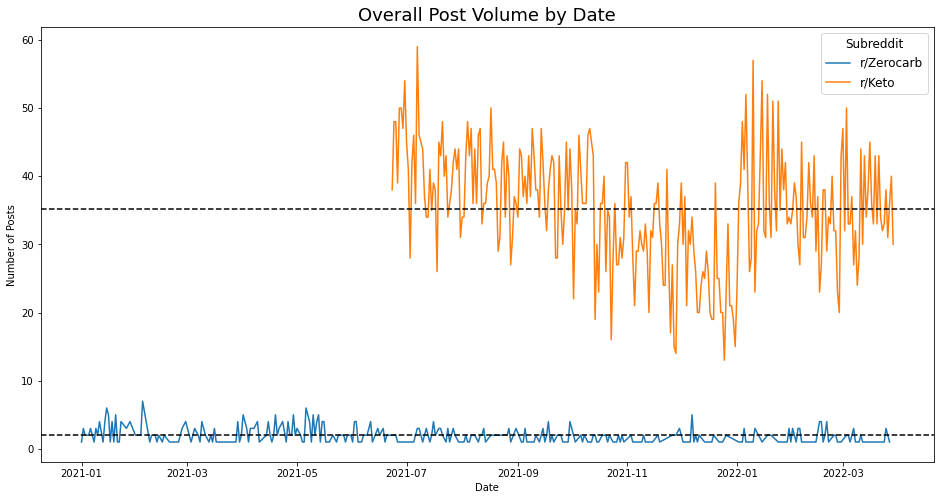

In [22]:
# exact same procedure as before, just filtering for after 2020

fig, ax = plt.subplots(1, 1, figsize=(16,8))
zerocarb.loc[zerocarb['year'] > 2020, 'date'].value_counts().plot()
mean_zerocarb = zerocarb.loc[zerocarb['year'] > 2020, 'date'].value_counts().mean()
keto['date'].value_counts().plot()
mean_keto = keto['date'].value_counts().mean()

plt.axhline(y=mean_zerocarb, ls='--', color='black')
plt.axhline(y=mean_keto, ls='--', color='black')

plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Overall Post Volume by Date', fontsize=18)
legend = plt.legend(title='Subreddit', loc='best', labels=['r/Zerocarb', 'r/Keto'], fontsize=12)
legend.get_title().set_fontsize('12');

The differnce between the post volume for each of the subreddits is quite obvious here. While it is possible that `r/zerocarb` has higher quality posts (as indicated by higher upvotes and number of comments), `r/keto` has people posting much more frequently. This could be due to the widespread knowledge of the ketogenic diet, or the more active moderators, prompting more activity on the `r/keto` subreddit which in turn may land the subreddit onto the main reddit page.

## Top Unigrams, Bigrams and Trigrams

### Top 20 Unigrams

In [23]:
# Create function to get top words
def plot_top_words(df, col, n, n_gram_range, title, palette='tab10'):
    """accepted dataframe, column name in text, number of words, 
    ngrams, title of chart and the color palette for chart"""
    
    def get_top_n_words(corpus, n=n, k=n_gram_range):
        """internal function that retruns top n words"""
        
        # countvectorizer to vectorize words in column
        vec = CountVectorizer(ngram_range=(k,k), stop_words='english').fit(corpus)     
        bag_of_words = vec.transform(corpus)     
        sum_words = bag_of_words.sum(axis=0)      
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]    
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
        return words_freq[:n]
    
    # create a DataFrame of top words
    temp_df = pd.DataFrame(data=get_top_n_words(df[col], n), columns=['word','freq'])
    
    # plot the figure
    plt.figure(figsize=(10,6))
    sns.barplot(data=temp_df, y='word', x='freq', palette=palette)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title, fontsize=18)

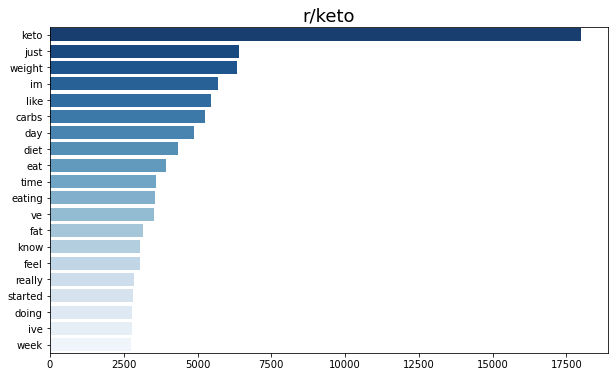

In [24]:
plot_top_words(keto,'c_text', 20, 1, 'r/keto', 'Blues_r')

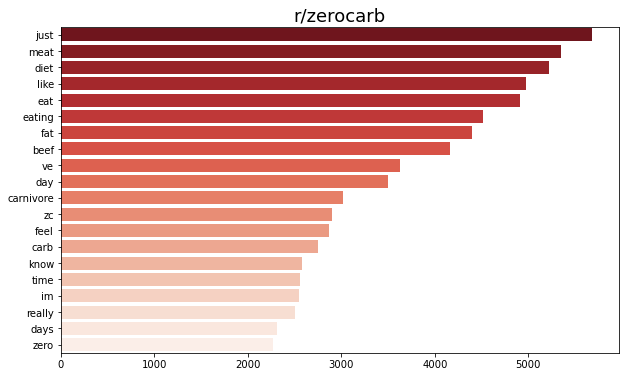

In [25]:
plot_top_words(zerocarb,'c_text', 20, 1, 'r/zerocarb', 'Reds_r')

We can see that both the two subreddits have quite a few similar words, 1 key difference is `r/keto` seems to mention weight, wherea `r/zerocarb` mentions diet, and certain foods, like 'beef'.

---

### Top 20 Bigrams

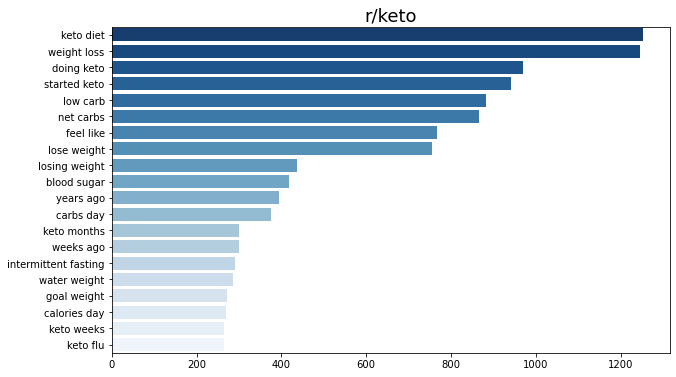

In [26]:
plot_top_words(keto,'c_text', 20, 2, 'r/keto', 'Blues_r')

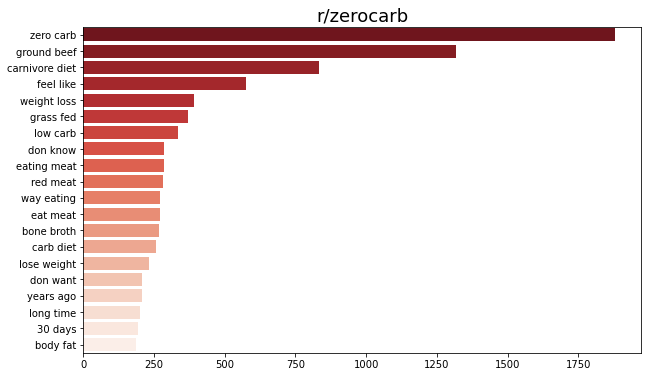

In [27]:
plot_top_words(zerocarb,'c_text', 20, 2, 'r/zerocarb', 'Reds_r')

With bigrams, we cannot see a clear picture of differences between the two subreddits. We will relook at this after removal of stop words.
Similar words are: 'weight loss', 'low carb'. 
The differences do not really have any themes for now.

---

### Top 20 Trigrams

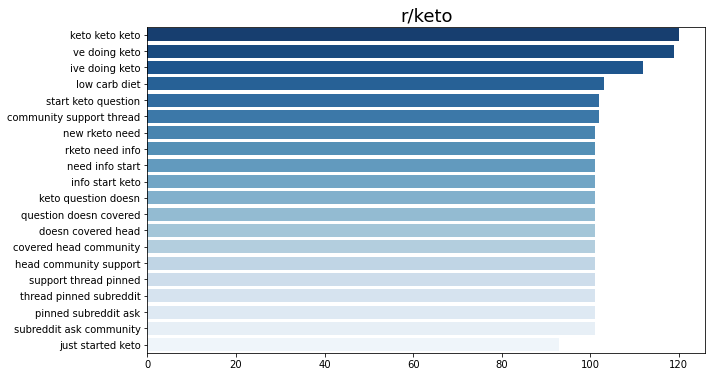

In [28]:
plot_top_words(keto,'c_text', 20, 3, 'r/keto', 'Blues_r')

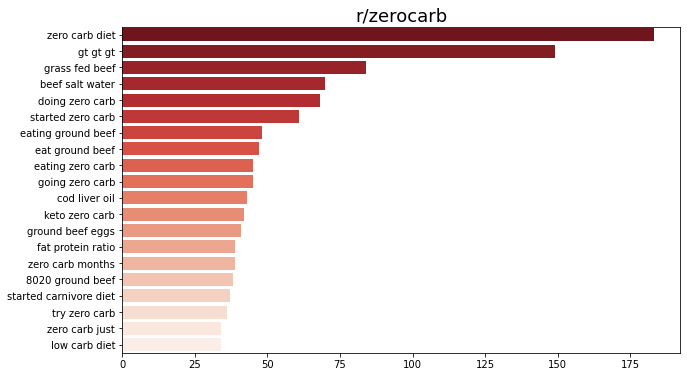

In [29]:
plot_top_words(zerocarb,'c_text', 20, 3, 'r/zerocarb', 'Reds_r')

From these words, we can clearly see that there are many stop words, like: 'keto', 'zero', 'carb, etc that, after removing might paint a clearer picture.

Otherwise we start to see a theme for the differences where `r/keto` has more question type posts and titles, where as `r/zerocarb` has more posts highlight food and nurtrition related items.

---

## Top Unigrams, Bigrams and Trigrams (After Custom Stop Words removal)

In the next notebook, we looked at the stop words in greater detail and created a custom_stop_words list. We will apply that to our charts above and plot them out again to see if there are any differences in the insights they provide.

In [30]:
custom_stop_words = pd.read_csv('datasets/custom_stop_words.csv')
custom_stop_words = custom_stop_words['words'].tolist()

In [31]:
# rewriting the plot_top_words function to use the custom_stop_words list
def plot_top_wordsV2(df, col, n, n_gram_range, title, palette='tab10'):
    def get_top_n_words(corpus, n=n, k=n_gram_range):     
        vec = CountVectorizer(ngram_range=(k,k), stop_words=custom_stop_words).fit(corpus)     
        bag_of_words = vec.transform(corpus)     
        sum_words = bag_of_words.sum(axis=0)      
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]    
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
        return words_freq[:n]
    temp_df = pd.DataFrame(data=get_top_n_words(df[col], n), columns=['word','freq'])
    plt.figure(figsize=(10,6))
    sns.barplot(data=temp_df, y='word', x='freq', palette=palette)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title, fontsize=18)

### Top Unigrams

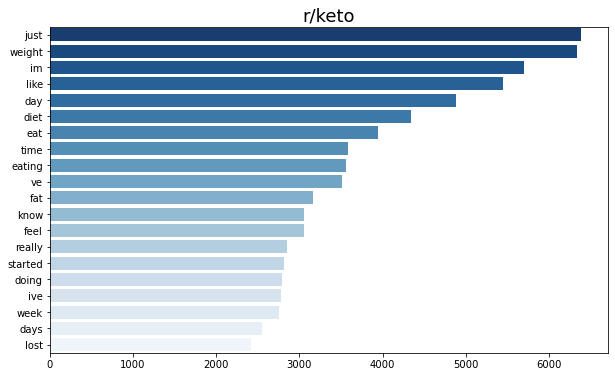

In [32]:
plot_top_wordsV2(keto,'c_text', 20, 1, 'r/keto', 'Blues_r')

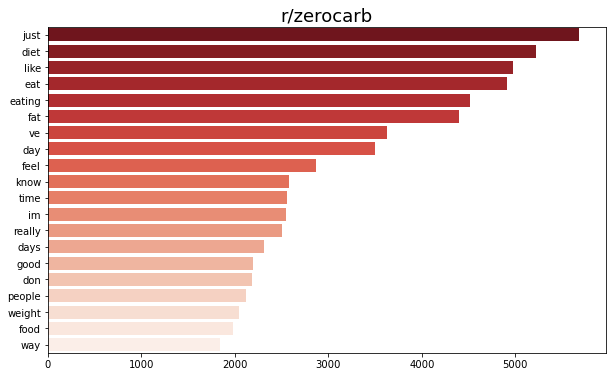

In [33]:
plot_top_wordsV2(zerocarb,'c_text', 20, 1, 'r/zerocarb', 'Reds_r')

One key difference between the two is that `r/zerocarb` seems to mention 'people', whereas `r/keto` does not. However we cannot make any assumption on what this might mean, let's take a look at bigrams, if it sheds any light on this.

---

#### Top 20 Bigrams

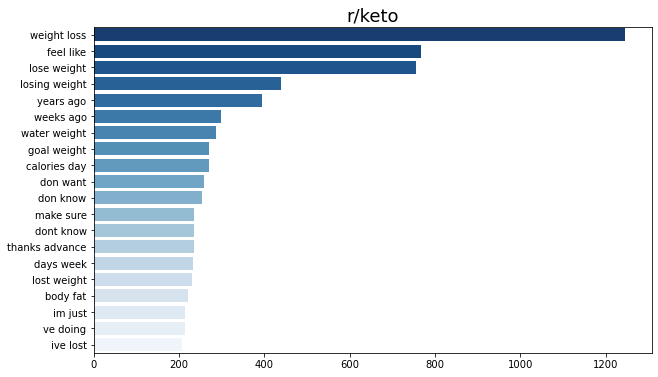

In [34]:
plot_top_wordsV2(keto,'c_text', 20, 2, 'r/keto', 'Blues_r')

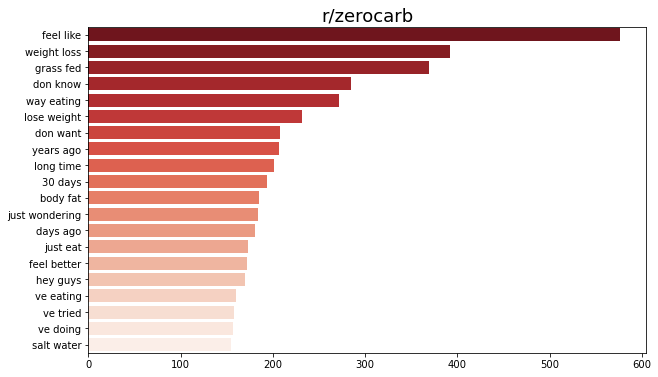

In [35]:
plot_top_wordsV2(zerocarb,'c_text', 20, 2, 'r/zerocarb', 'Reds_r')

Both the two subreddits mention 'weight loss' quite a bit. This is to be expected as they are both generally speaking about diets, that have been shown to work well to lose weight. Interestingly, `r/zerocarb` mentions '30 days'. This might mean that quite a few people do not look at the 'zerocarb' diet as a lifestyle, but more as a temporary lifestyle change.

___

#### Top 20 Trigrams

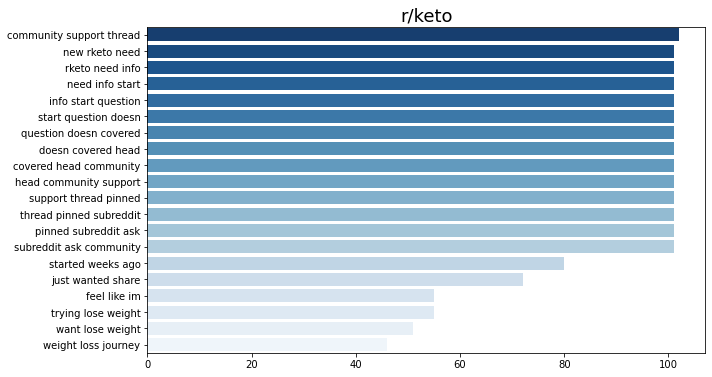

In [36]:
plot_top_wordsV2(keto,'c_text', 20, 3, 'r/keto', 'Blues_r')

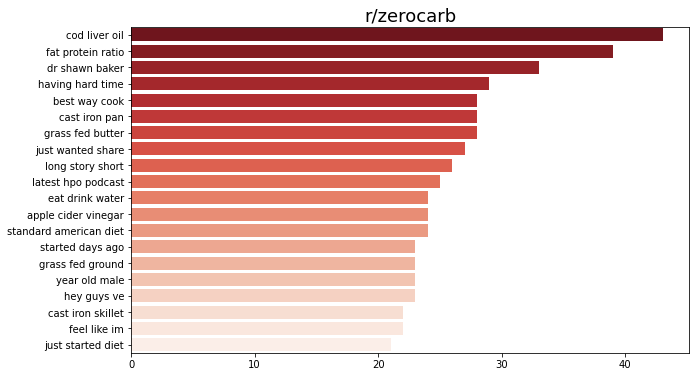

In [37]:
plot_top_wordsV2(zerocarb,'c_text', 20, 3, 'r/zerocarb', 'Reds_r')

After removal of the stop words, we can see that on the `r/keto` subreddit, the users ask a lot more questions, and they are trying to find out more information about the ketogenic diet. On the `r/zerocar`b subreddit however, it seems that users are talking about specific foods, and even cooking methods. This indicates to me that most users on `r/zerocarb` already know what they are doing in terms of their diet, however on `r/keto`, there may be many more newbies. 

---

Now that we have done some EDA, let's start building our model in the next notebook.